# Neural Networks and Intelligent Systems
# NTUA AILS Lab
## Εργαστηριακή Άσκηση:
$\textbf{Introduction to Deep Learning: Convolutional Neural Networks and TensorFlow 2.1.0}$

# Στοιχεία Ομάδας
Αρ. Ομάδας: $01$ <br>
Μαρία Παναγιώτου, $03116703$ <br>
Κωνσταντίνος Αλεξάνδρου, $03116708$ <br>
Ματθαίος Φικάρδος, $03116705$ <br>

# Βαθιά μάθηση στο CIFAR-100

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# baseline model with dropout on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

## Αρχικοποίηση Παραμέτρων

In [2]:
#Αριθμός κλάσεων
classes_num = 20 # (20,40,60,80)

#Batch size
batch_size_initial = 64

#Learning Rate
learning_rates = 1.5e-4

#Resize 
image_resize_initial = 32
img_rows = 32
img_cols = 32
img_channels =3

#Dropout
dropout_rate = 0.5

#Epochs
epoxes = 50



In [3]:
# helper functions

# select from from_list elements with index in index_list
def select_from_list(from_list, index_list):
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

# append in filtered_list the index of each element of unfilterd_list if it exists in in target_list
def get_ds_index(unfiliterd_list, target_list):
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

# select a url for a unique subset of CIFAR-100 with 20, 40, 60, or 80 classes
def select_classes_number(classes_number = 20):
  cifar100_20_classes_url = "https://pastebin.com/raw/nzE1n98V"
  cifar100_40_classes_url = "https://pastebin.com/raw/zGX4mCNP"
  cifar100_60_classes_url = "https://pastebin.com/raw/nsDTd3Qn"
  cifar100_80_classes_url = "https://pastebin.com/raw/SNbXz700"
  if classes_number == 20:
    return cifar100_20_classes_url
  elif classes_number == 40:
    return cifar100_40_classes_url
  elif classes_number == 60:
    return cifar100_60_classes_url
  elif classes_number == 80:
    return cifar100_80_classes_url
  else:
    return -1

In [4]:
# load the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169009152/169001437 [==============================] - 2s 0us/step


In [5]:
print(x_train_all.shape)

(50000, 32, 32, 3)


In [6]:
# REPLACE WITH YOUR TEAM NUMBER
team_seed = 1

In [7]:
# select the number of classes
cifar100_classes_url = select_classes_number(classes_num)

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [8]:
team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None)
CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

our_index = team_classes.iloc[team_seed,:].values.tolist()
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index)
train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

In [9]:
# print our classes
print(our_classes)

[' beaver', ' bridge', ' caterpillar', ' cup', ' leopard', ' lizard', ' lobster', ' motorcycle', ' mouse', ' otter', ' pine_tree', ' porcupine', ' possum', ' rabbit', ' skunk', ' table', ' telephone', ' tractor', ' turtle', ' wolf']


In [10]:
CLASSES_NUM=len(our_classes)

In [11]:
print(x_train_ds[1].shape)

(32, 32, 3)


1500
Train: X=(8500, 32, 32, 3), y=(8500, 1)
Validation: X=(1500, 32, 32, 3), y=(1500, 1)
Test: X=(2000, 32, 32, 3), y=(2000, 1)


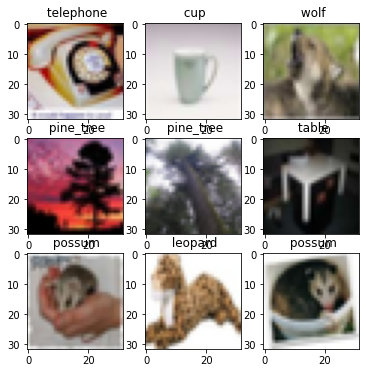

In [12]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα data prefetch του tf2:

In [13]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

#Callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=4,restore_best_weights=True) 
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  #train with callbacks (EarlyStopping , ModelCheckpoint )
  #history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps, callbacks=[early_stop_callback,mc])
  return(history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [14]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

## Μοντέλα δικτύων

### Ένα μικρό συνελικτικό δίκτυο "from scratch"

In [15]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

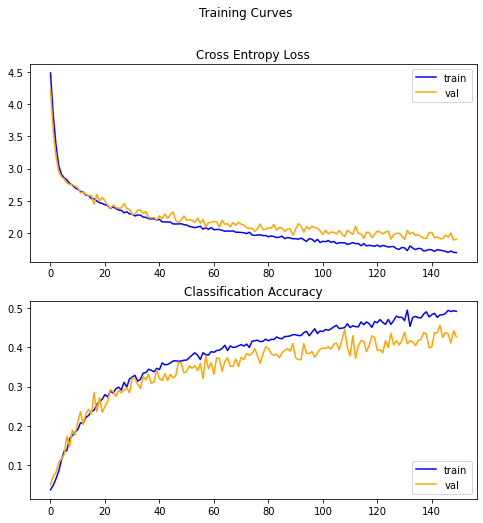


Test set evaluation metrics
10/10 [==============================] - 0s 5ms/step - loss: 2.0359 - accuracy: 0.4102
loss: 2.04
accuracy: 0.41


In [16]:
SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 150, 40, 5)

# model report
model_report(SIMPLE_MODEL, SIMPLE_MODEL_history, evaluation_steps = 10)

### Μεταφορά μάθησης: VGG16

In [17]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary):
  vgg_model=tf.keras.applications.VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')
  
  VGG16_MODEL=vgg_model.layers[0](vgg_model)

  # unfreeze conv layers
  VGG16_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [18]:
VGG16_MODEL = init_VGG16_model(True)
VGG16_MODEL_history = train_model(VGG16_MODEL, 25, 40, 10)

#model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
40/40 [==============================] - 8s 134ms/step - loss: 4.2513 - accuracy: 0.0725 - val_loss: 2.3749 - val_accuracy: 0.3477
Epoch 2/25
40/40 [===============

# Βελτίωση της επίδοσης με πειράματα

Καλούμαστε να βελτιώσετε τα αποτελέσματα ταξινόμησης στο CIFAR-100 και να βγάλουμεε συμπεράσματα, σύμφωνα με όσα ζητούνται σε σχέση με την αναφορά παράδοσης. 

## Δοκιμές διαφορετικών μοντέλων

Μπορείτε είτε να δοκιμάσετε μοντέλα "from scratch", όπου ορίζετε την αρχιτεκτονική του δικτύου όπως θέλετε, είτε να χρησιμοποιήσετε μεταφορά μάθησης.



### Μοντέλα "from scratch"

Μπορείτε να τροποποιήσετε/αλλάξετε το αρχικό μικρό συνελικτικό δίκτυο του παραδείγματος. Μπορείτε να συμβουλευτείτε 
- τη [βιβλιογραφία απο το leaderboard του CIFAR-100](https://benchmarks.ai/cifar-100) για αρχιτεκτονικές και παραμέτρους των δικτύων
- ή/και να πάρετε ιδέες [από σχετική αναζήτηση στο Google Scholar](https://scholar.google.gr/scholar?hl=en&as_sdt=0%2C5&q=cifar+100+cnn&oq=cifa)

In [19]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# kodikas gia kapoia montela from scrach
# diki mas arxitektoniki opws theloume - CNN 
def define_model(summary):
  init = 'he_uniform'
  #init = 'he_normal'
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='elu',kernel_initializer=init, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), input_shape=(32,32,3)))
  model.add(BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='elu',kernel_initializer=init, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  model.add(layers.Conv2D(64, (3, 3), activation='elu',kernel_initializer=init, kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001), padding = 'same'))
  model.add(BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='elu',kernel_initializer=init, kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001), padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  model.add(BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='elu',kernel_initializer=init, kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001), padding = 'same'))
  model.add(layers.Conv2D(128, (3, 3), activation='elu', kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001), padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))

  model.add(BatchNormalization())
  model.add(layers.Conv2D(256, (3, 3), activation='elu',kernel_initializer=init, kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001), padding = 'same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001), padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.4))

  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='elu',kernel_initializer=init,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
  model.add(layers.Dense(100, activation='softmax'))
  
  # Change Optimizer and learning rate
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00015), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  #model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  #model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  #model.compile(optimizer=tf.optimizers.Nadam(learning_rate=0.00015), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  
  if summary: 
    model.summary()
  return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)       

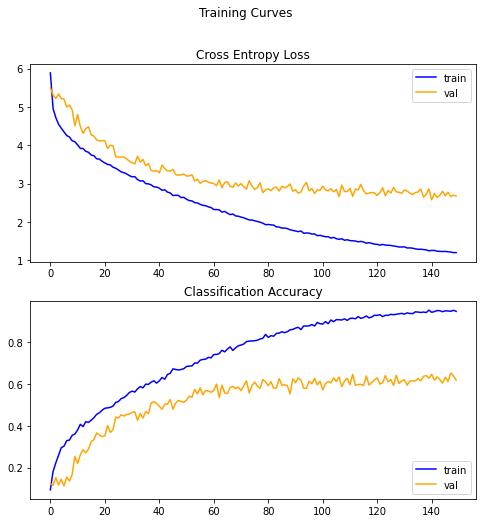


Test set evaluation metrics
10/10 [==============================] - 0s 15ms/step - loss: 2.7147 - accuracy: 0.6141
loss: 2.71
accuracy: 0.61


In [20]:
CNN = define_model(summary = True)
CNN_history = train_model(CNN, 150, 40, 5)

# model report
model_report(CNN, CNN_history, evaluation_steps = 10)

### Μεταφορά μάθησης

Εναλλακτικά, μπορείτε να χρησιμοποιήσετ τη [μεταφορά μάθησης του tf2](https://www.tensorflow.org/tutorials/images/transfer_learning). Σε αντίθεση με τα μοντέλα "from scratch" η μεταφορά μάθησης μας επιστρέφει έτοιμα μοντέλα με προκαθορισμένη αρχιτεκτονική στην οποία μπορούμε γενικά μόνο να προσθέσουμε επίπεδα, τα οποία συνήθως περιορίζοντα σε πλήρως διασυνδεδεμένα επίπεδα που εξειδικεύονται στο συγκεκριμένο task ταξινόμησης που έχουμε να επιτελέσουμε. 

#### Εκπαίδευση βαρών

Ταυτόχρονα με την αρχιτεκτονική, στη μεταφορά μάθησης εισάγουμε και τη γνώση που έχει αποκτήσει το μοντέλο, δηλαδή τις τιμές των βαρών του όπως έχουν προκύψει μετά από εκπαίδευση συνήθως στο (τεράστιο) ImageNet. Οταν εισάγουμε ένα μοντέλο με μεταφορά μάθησης έχουμε τρεις επιλογές για την εκπαίδευση:
- να παγώσουμε τη συνελικτική βάση και να εκπαιδεύσουμε την κεφαλή ταξινόμησης (classification head). Αυτό αντιστοιχεί στο να χρησιμοποιήσουμε τη συνελικτική βάση για εξαγωγή χαρακτηριστικών (feature extraction), σημαία trainable = False.
- να συνεχίσουμε να εκπαιδεύουμε όλα τα επίπεδα του δικτύου, σημαία trainable = True.
- να εκπαιδευτεί μόνο ένα ποσοστό των επιπέδων, εβρισκόμενο προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.



#### Διαθέσιμα μοντέλα για μεταφορά μάθησης στο tf2

1. tf.keras.applications. Ο πιο απλός τρόπος για να κάνουμε μεταφορά μάθησης στο tf2 είναι μέσω του [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) που παρέχει προεκπαιδευμένα μοντέλα από το Keras και συγκεκριμένα τα δίκτυα: DenseNet, Inception-ResNet V2, Inception V3, MobileNet v1, MobileNet v2, NASNet-A, ResNet, ResNet v2, VGG16, VGG19 και Xception V1. Η εισαγωγή των μοντέλων γίνεται παρόμοια με αυτή που δείξαμε παραπάνω για το VGG16.

2. TensorFlow Hub. Μπορείτε επίσης να χρησιμοποιήσετε μοντέλα τα οποία είναι διαθέσιμα στο αποθετήριο [TensoFlow Hub](https://tfhub.dev/s?fine-tunable=yes&module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent&tf-version=tf2) το οποίο περιλαμβάνει πάνω από 100 προεκπαιδευμένα μοντέλα.

3. Αποθηκευμένα μοντέλα απο τρίτες πηγές. Μπορείτε επίσης να κάνετε μεταφορά μάθησης από τρίτες πηγές, είτε του συνόλου του νευρωνικού, αρχιτεκτονικής και βαρών, είτε μόνο της αρχιτεκτονικής ή των βαρών. Το μοντέλο θα πρέπει να έχει αποθηκευθεί σε ένα από τα δύο φορμάτ, Keras HDF5 format (.h5 ή .keras) ή στο SavedModel format που αναφέραμε στην εισαγωγή. Τα βάρη μπορούν να εισαχθούν και μόνα τους ως Checkpoints. Για περισσότερα, διαβάστε σχετικά τα λήμματα ["Save and load models"](https://www.tensorflow.org/tutorials/keras/save_and_load), ["Save and serialize"](https://www.tensorflow.org/guide/keras/save_and_serialize), ["Using the SavedModel format"](https://www.tensorflow.org/guide/saved_model) και δείτε για παράδειγμα πως μπορούμε να κάνουμε μεταφορά μάθησης από τα state-of-the-art EfficientNets ([1](https://www.dlology.com/blog/transfer-learning-with-efficientnet/), [2](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnethttps://)).

Σημειώστε ότι πολλά μοντέλα απαιτούν μεγαλύτερες διαστάσεις στην είσοδο από αυτές του CIFAR-100 και κατά συνέπεια τα δεδομένα πρέπει να [μετασχηματιστούν](https://www.tensorflow.org/api_docs/python/tf/image/resize). Προσέξτε ωστόσο τις απαιτήσεις σε μνήμη όταν αυτοί οι μετασχηματισμοί γίνονται απευθείας σε μεταβλητές (βλ. πιο κάτω "Διαχείριση μνήμης"). 


Επιλέξαμε να χρησιμοπιήσουμε τα δίκτυα VGG16, VGG19 και DenseNet.

In [21]:
#Models initialization

def init_VGG16_model(summary):
  print(img_rows, img_cols, img_channels)
  vgg_model=tf.keras.applications.VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')
  
  VGG16_MODEL=vgg_model.layers[0](vgg_model)

  # unfreeze conv layers
  VGG16_MODEL.trainable=True

  #fine tuning 0-19
  fine_tune = 0
  for layer in VGG16_MODEL.layers[:fine_tune]:
    layer.trainable = False
  
  dropout_layer = tf.keras.layers.Dropout(rate = dropout_rate)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rates), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

def init_VGG19_model(summary):
    vgg_model=tf.keras.applications.VGG19(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')
    
    VGG19_MODEL=vgg_model.layers[0](vgg_model)

    # unfreeze conv layers
    VGG19_MODEL.trainable=True

    #fine tuning 0-22
    fine_tune = 0
    for layer in VGG19_MODEL.layers[:fine_tune]:
      layer.trainable = False
    
    dropout_layer = tf.keras.layers.Dropout(rate = dropout_rate)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    
    # add top layer for CIFAR100 classification
    prediction_layer1 = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
    model = tf.keras.Sequential([VGG19_MODEL, dropout_layer, global_average_layer, prediction_layer1])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rates), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
    if summary: 
      model.summary()
    return model

def init_densenet_model(summary):
    densenet_model=tf.keras.applications.densenet.DenseNet121(input_shape=(img_rows, img_cols, img_channels),include_top=False,weights='imagenet')

    # unfreeze conv layers
    densenet_model.trainable = True
    dropout_layer = tf.keras.layers.Dropout(rate= dropout_rate)
    dropout_layer.trainable = True
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    global_average_layer.trainable = True

    #fine tuning 0-427
    fine_tune = 0
    for layer in densenet_model.layers[:fine_tune]:
      layer.trainable = False
      
    # add top layer for CIFAR100 classification
    prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
    model = tf.keras.Sequential([densenet_model, dropout_layer, global_average_layer, prediction_layer])
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rates),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
    if summary: 
      model.summary()
    return model

In [22]:
#set batch size to run
BATCH_SIZE = batch_size_initial

# Creating PrefetchDataset objects
train_ds =_input_fn(x_train, y_train, BATCH_SIZE)
validation_ds =_input_fn(x_val, y_val, BATCH_SIZE) 
test_ds =_input_fn(x_test, y_test, BATCH_SIZE)

### Αρχική δοκιμή των models χωρίς βλετιστοποιήσεις.

32 32 3
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 13s 79ms/step - loss: 3.4792 - accuracy: 0.1353 - val_loss: 1.8661 - val_accuracy: 0.4688
Epoch 2/50
133/133 [==============================] - 10s 76ms/step - loss: 1.8153 - acc

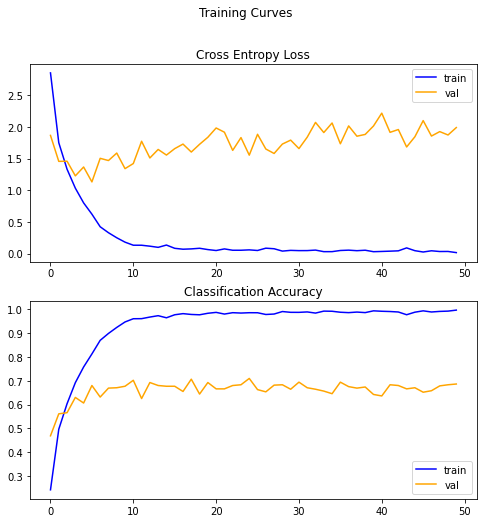


Test set evaluation metrics
30/30 [==============================] - 1s 22ms/step - loss: 1.8394 - accuracy: 0.6922
loss: 1.84
accuracy: 0.69


In [23]:
VGG16_MODEL = init_VGG16_model(True)
VGG16_MODEL_history = train_model(VGG16_MODEL, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10)
model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 14s 96ms/step - loss: 3.9966 - accuracy: 0.0618 - val_loss: 2.7624 - val_accuracy: 0.2250
Epoch 2/50
133/133 [===========

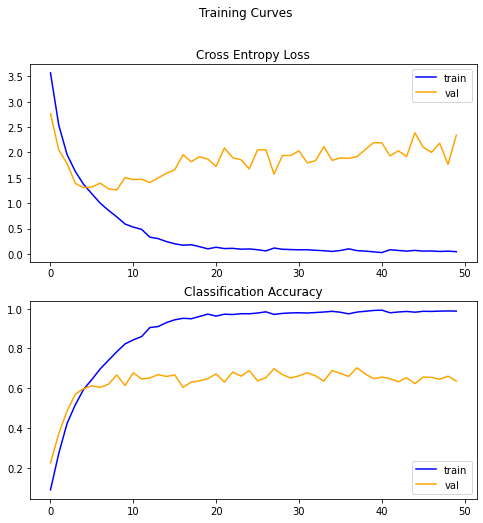


Test set evaluation metrics
30/30 [==============================] - 1s 27ms/step - loss: 2.2800 - accuracy: 0.6240
loss: 2.28
accuracy: 0.62


In [24]:
VGG19_MODEL = init_VGG19_model(True)
VGG19_MODEL_history = train_model(VGG19_MODEL, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10)
model_report(VGG19_MODEL, VGG19_MODEL_history, 30)

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               102500    
Total params: 7,140,004
Trainable params: 7,056,356
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 29s 109ms/step - loss: 4.5738 - accuracy: 0.0922 - val_loss: 2.9588 - val_accuracy: 0.3156
Epoch 2/50
133/133 [=======

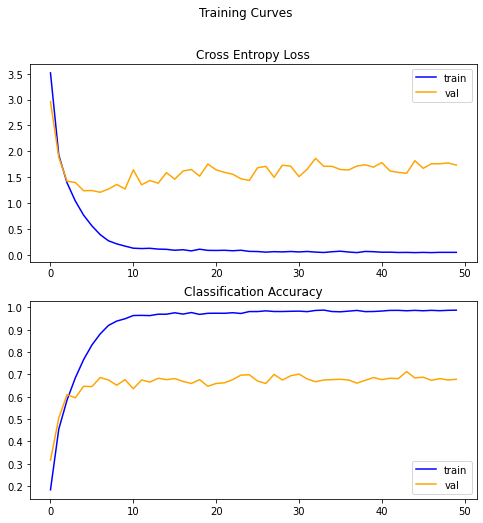


Test set evaluation metrics
30/30 [==============================] - 1s 32ms/step - loss: 1.8423 - accuracy: 0.6792
loss: 1.84
accuracy: 0.68


In [25]:
densenet_model = init_densenet_model(summary = True)
densenet_model_history = train_model(densenet_model, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10)
model_report(densenet_model, densenet_model_history, 30)

### Επαύξηση δεδομένων

Μια τεχνική που μπορεί να σας δώσει καλά αποτελέσματα είναι η επάυξηση δεδομένων (data augmentation). Η επαύξηση δεδομένων επιτρέπει να δημιουργήσουμε μεγαλύτερη ποικιλία στα δεδομένα εφαρμόζοντας τυχαίους αλλά ρεαλιστικούς μετασχηματισμούς στις εικόνες, όπως πχ η περιστροφη.

Μπορούμε να κάνουμε data augmetation με δύο τρόπους: με επίπεδα προεπεξεργασίας του Keras, ή με χρήση του tf.image. Δείτε [εδώ](https://www.tensorflow.org/tutorials/images/data_augmentation) σχετικά από το documentation του TensorFlow και [εδώ](https://stepup.ai/train_data_augmentation_keras/) ένα πρακτικό παράδειγμα στο CIFAR-10.

## Data Augmentation

In [26]:
# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

image_augmentation_gen = ImageDataGenerator(
                        rotation_range = 17,
                        width_shift_range = .11,
                        height_shift_range = .11,
                        horizontal_flip = True,
                        vertical_flip = True,
                    )

Για το Data Augmentation χρίαζεται να μετασχηματίσουμε τα labels του dataset μας.

In [27]:
#Convert labels
# find unique labels using a dict -- key: real label, value: transformed label
labels = {}
for i,label in enumerate(np.unique(y_train)):
    labels[label] = i

print(labels)

# transform y sets
y_train_augm = [labels[int(label)] for label in y_train]
y_val_augm = [labels[int(label)] for label in y_val]
y_test_augm = [labels[int(label)] for label in y_test]

{4: 0, 12: 1, 18: 2, 28: 3, 42: 4, 44: 5, 45: 6, 48: 7, 50: 8, 55: 9, 59: 10, 63: 11, 64: 12, 65: 13, 75: 14, 84: 15, 86: 16, 89: 17, 93: 18, 97: 19}


In [28]:
#Prepare train_ds augmented
BATCH_SIZE = batch_size_initial

# Creating PrefetchDataset objects
train_ds =_input_fn(x_train,y_train_augm, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val_augm, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test_augm, 1) #PrefetchDataset object

image_augmentation_gen.fit(x_train)
train_ds = image_augmentation_gen.flow(x=x_train,
                                y=y_train_augm,
                                batch_size=batch_size_initial,
                                shuffle=True)

Δοκιμή models με Data Augmentation.

32 32 3
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 12s 86ms/step - loss: 3.8063 - accuracy: 0.0935 - val_loss: 2.3257 - val_accuracy: 0.3016
Epoch 2/50
133/133 [==============================] - 10s 77ms/step - loss: 2.4667 - acc

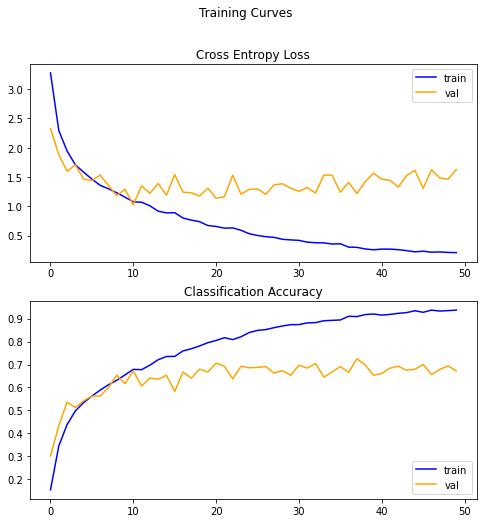


Test set evaluation metrics
30/30 [==============================] - 1s 8ms/step - loss: 1.3546 - accuracy: 0.6333
loss: 1.35
accuracy: 0.63


In [29]:
VGG16_MODEL = init_VGG16_model(True)
VGG16_MODEL_history = train_model(VGG16_MODEL, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10)
model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 14s 97ms/step - loss: 4.4771 - accuracy: 0.0328 - val_loss: 3.5725 - val_accuracy: 0.0375
Epoch 2/50
133/133 [==============================] - 13s 95ms/step - loss: 3.6970 - accuracy: 0

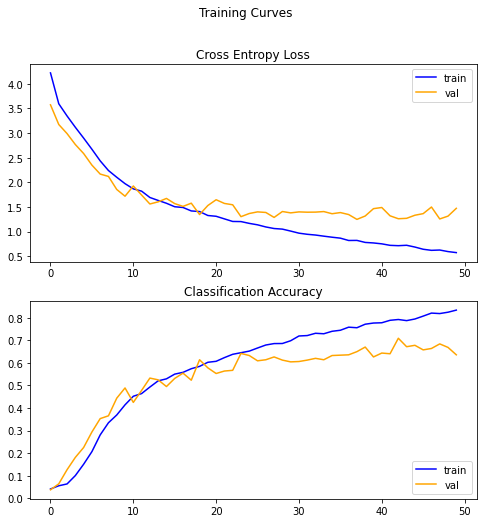


Test set evaluation metrics
30/30 [==============================] - 0s 11ms/step - loss: 0.9912 - accuracy: 0.7667
loss: 0.99
accuracy: 0.77


In [30]:
VGG19_MODEL = init_VGG19_model(True)
VGG19_MODEL_history = train_model(VGG19_MODEL, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10)
model_report(VGG19_MODEL, VGG19_MODEL_history, 30)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1, 1, 1024)        7037504   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 1, 1024)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               102500    
Total params: 7,140,004
Trainable params: 7,056,356
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 30s 136ms/step - loss: 4.5792 - accuracy: 0.0791 - val_loss: 3.1282 - val_accuracy: 0.2641
Epoch 2/50
133/133 [==============================] - 13s 101ms/step - loss: 2.5450 - accura

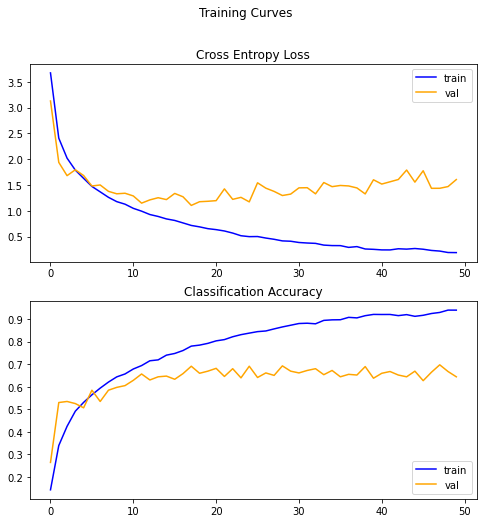


Test set evaluation metrics
30/30 [==============================] - 1s 22ms/step - loss: 1.9779 - accuracy: 0.5333
loss: 1.98
accuracy: 0.53


In [31]:
densenet_model = init_densenet_model(summary = True)
densenet_model_history = train_model(densenet_model, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10) 
model_report(densenet_model, densenet_model_history, 30)

## Επίδραση του μεγέθους των εικόνων 

In [32]:
img_rows = 64
img_cols = 64
img_rows, img_cols, img_channels

x_train_resize = tf.image.resize(x_train, (img_rows,img_cols))
x_test_resize  = tf.image.resize(x_test, (img_rows,img_cols))
x_val_resize  = tf.image.resize(x_val, (img_rows,img_cols))

In [33]:
print(x_train_resize.shape)
print(x_train.shape)


(8500, 64, 64, 3)
(8500, 32, 32, 3)


In [34]:
#get new tain_ds
BATCH_SIZE = batch_size_initial

# Creating PrefetchDataset objects
train_ds =_input_fn(x_train_resize,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val_resize,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test_resize,y_test, 1) #PrefetchDataset object

64 64 3
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               51300     
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 26s 171ms/step - loss: 2.8578 - accuracy: 0.2276 - val_loss: 1.4895 - val_accuracy: 0.5250
Epoch 2/50
133/133 [==============================] - 22s 168ms/step - loss: 1.2513 - a

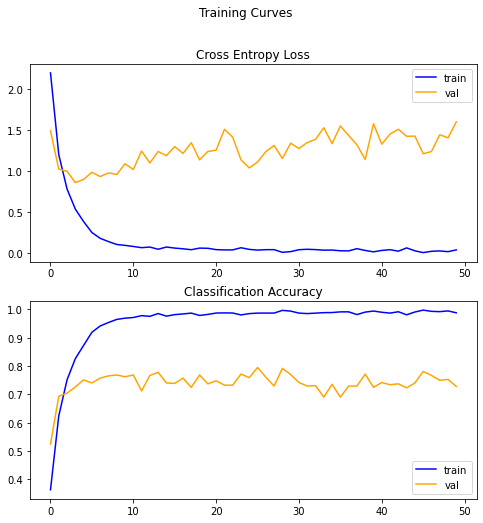


Test set evaluation metrics
30/30 [==============================] - 1s 9ms/step - loss: 1.3004 - accuracy: 0.7667
loss: 1.30
accuracy: 0.77


In [35]:
VGG16_MODEL = init_VGG16_model(True)
VGG16_MODEL_history = train_model(VGG16_MODEL, epoxes , np.ceil(x_train_resize.shape[0] / batch_size_initial), 10)
model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 2, 512)         0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 29s 205ms/step - loss: 3.2542 - accuracy: 0.1425 - val_loss: 1.7024 - val_accuracy: 0.4688
Epoch 2/50
133/133 [==============================] - 27s 203ms/step - loss: 1.6113 - accuracy

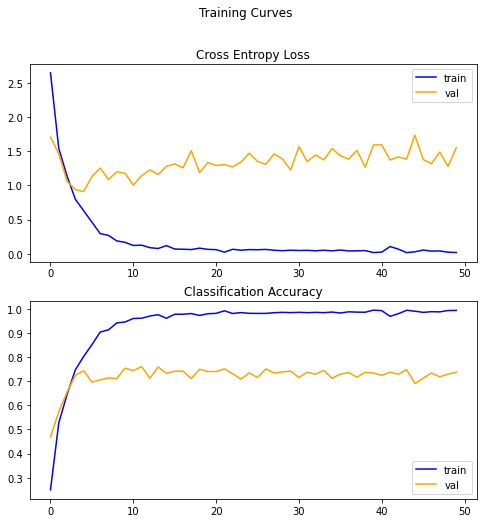


Test set evaluation metrics
30/30 [==============================] - 1s 12ms/step - loss: 0.8408 - accuracy: 0.8667
loss: 0.84
accuracy: 0.87


In [36]:
VGG19_MODEL = init_VGG19_model(True)
VGG19_MODEL_history = train_model(VGG19_MODEL, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10)
model_report(VGG19_MODEL, VGG19_MODEL_history, 30)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 2, 1024)        0         
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               102500    
Total params: 7,140,004
Trainable params: 7,056,356
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 39s 197ms/step - loss: 3.2031 - accuracy: 0.3020 - val_loss: 1.5273 - val_accuracy: 0.5703
Epoch 2/50
133/133 [==============================] - 24s 182ms/step - loss: 0.6311 - accur

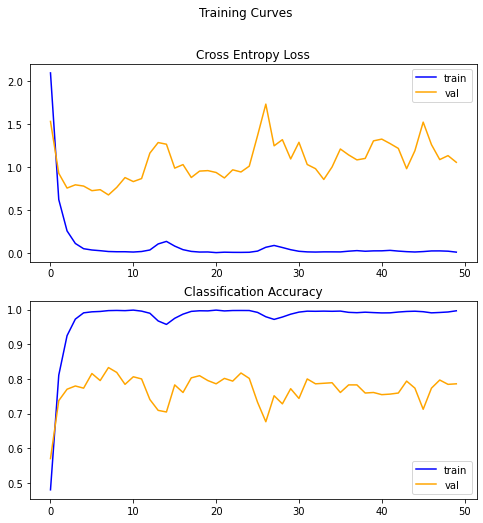


Test set evaluation metrics
30/30 [==============================] - 1s 22ms/step - loss: 1.2469 - accuracy: 0.7667
loss: 1.25
accuracy: 0.77


In [37]:
densenet_model = init_densenet_model(summary = True)
densenet_model_history = train_model(densenet_model, epoxes , np.ceil(x_train.shape[0] / batch_size_initial), 10) 
model_report(densenet_model, densenet_model_history, 30)

# Augmentation & Resize



In [38]:
#Prepare train_ds augmented
BATCH_SIZE = batch_size_initial

# Creating PrefetchDataset objects
train_ds =_input_fn(x_train,y_train_augm, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val_resize,y_val_augm, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test_resize,y_test_augm, 1) #PrefetchDataset object

image_augmentation_gen.fit(x_train)
train_ds = image_augmentation_gen.flow(x=x_train_resize,
                                y=y_train_augm,
                                batch_size=batch_size_initial,
                                shuffle=True)

# Fine Tuning
Για το Fine Tuning αλλάζαμε τον κώδικα έκει που ορίξαμε τα μοντέλα μας VGG16, VGG19, DensNet έτσι ώστε να κάνουμε freeze τα απαραίτητα layers.

## Παρατηρήσεις ως προς τη βελτιστοποίηση

### Διαχείριση μνήμης (TFRecord)

Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι καθόλου αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούνα να αναγνωστούν γραμμικά. Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε τα σχετικά λήμματα [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data). 

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).



### Υπερεκπαίδευση

Μπορείτε να πειραματιστείτε ως προς τον έλεγχο της υπερεκπαίδευσης (overfitting) με διάφορους τρόπους. Μεταξύ αυτών μπορούμε να αναφέρουμε τους εξής:
- Πρόωρος τερματισμός (early stopping). Μια μέθοδος που τερματίζει την εκπαίδευση αν δεν υπάρχει βελτίωση ως προς τη μετρική απόδοσης που παρακολουθούμε. [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStoppinghttps://)
- Dropout. Μια άλλη τεχνική για τη μείωση της υπερεκπαίδευσης είναι το Dropout. Είναι ένα είδος ομαλοποίησης (regularization) που επιβάλλει στα βάρη του δικτύου να παίρνουν μόνο μικρές τιμές. Εάν εφαρμόσουε dropout σε ένα επίπεδο του δικτύου, τότε ένα ποσοστό των βαρών του γίνεται τυχαία μηδενικό κατά την εκπαίδευση. [Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout)
- Επαύξηση δεδομένων. Η υπερεκπαίδευση συνήθως συμβαίνει όταν έχουμε λίγα ή/και πολύ όμοια δεδομένα εκπαίδευσης. Ένας τρόπος να διορθωθεί αυτό το πρόβλημα είναι να αυξήσουμε τα δεδομένα (data augmentation). Το data augmentation δημιουργεί νέα δεδομένα εκπαίδευσης με βάση τα υπάρχοντα εφαρμόζοντας τυχαίους μετασχηματισμούς ώστε να προκύπτουν αληθοφανείς εικόνες. [Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator)

Βλέπε επίσης [Image classification](https://www.tensorflow.org/tutorials/images/classification).